In [1157]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import torch 

In [1158]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs = [-0.5], observables=[qml.PauliZ(0)])

In [1159]:
# Global Parameters
Tau_global = torch.tensor(0)   # Dephase tau
Gamma_ps_global = torch.tensor(0)
Paras_global = torch.tensor([0, 0], dtype=torch.float)
Phi_global = torch.tensor(0, dtype=torch.float)

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""
    
    return 1 - torch.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [1160]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z = Paras_global[1]
    
    gamma_dephase = Dephase_factor(Tau_global)  

    qml.RX(torch.pi/2, wires = 0)

    qml.ApproxTimeEvolution(H, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0) 

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

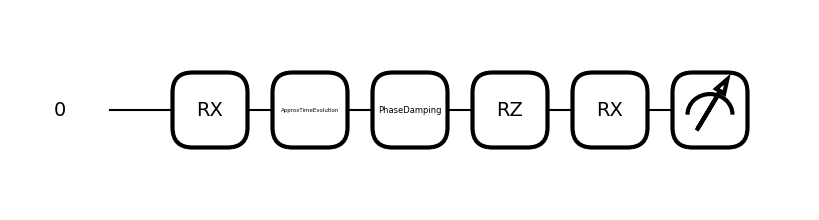

In [1161]:
fig, ax = qml.draw_mpl(circuit)(1)

In [1162]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def Post_selection(phi):
    
    global Paras_global, Gamma_ps_global
    
    density_matrix = circuit(phi)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = torch.tensor([
        [torch.sqrt(1 - Gamma_ps_global), 0],
        [0, 1]
    ], dtype=torch.complex128)
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = torch.trace(Numerator)
    rho_ps = Numerator / Denominator

    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

In [1163]:
def cost_function(paras):
    
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(circuit)(Phi_global)
    
    return -CFI

In [1164]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    global Tau_global, Gamma_ps_global 
    
    Tau_global = torch.tensor(desired_tau_dephase)
    Gamma_ps_global = torch.tensor(desired_gamma_post_selection)

In [1165]:
# def plot_optimization_result(sweep_range)



In [1166]:
# phi = torch.arange(0,to)

In [1167]:
def primative():
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # params_t = torch.tensor([np.pi/2, np.pi/3], requires_grad=True, device=device)
    # params_t = torch.tensor(params, requires_grad=True, device=torch.device('mps'))

    # params_t = params_t.detach().clone().requires_grad_(True)

    # params_t = torch.tensor([np.pi/3, np.pi/3], requires_grad=True)

    params_t = torch.tensor([1.0, torch.pi/2], requires_grad=True)

    Circuit_select_global = Post_selection
    Phi_global = torch.tensor([torch.pi*2])

    # opt = torch.optim.LBFGS([params_t])
    # opt = torch.optim.Adam([params_t])
    opt = torch.optim.LBFGS(
        [params_t], 
        lr=0.01,              # Learning rate
        max_iter=20,          # Maximum number of iterations per optimization step
        max_eval=None,        # Maximum number of function evaluations per optimization step
        tolerance_grad=1e-7,  # Termination tolerance on the gradient norm
        tolerance_change=1e-9,# Termination tolerance on the function value/parameter changes
        history_size=100      # Update history size
    )

    steps = 500

    f_logs = [cost_function(params_t).item()]
    ftol = 1e-10

    def closure():
        opt.zero_grad()
        loss = cost_function(params_t)
        loss.backward()
        return loss

    for i in range(steps):
        opt.step(closure)
        fval = cost_function(opt.param_groups[0]['params'][0]).item()
        print(f"{i+1:03d}th iteration, CFI=", fval)
        f_logs.append(fval)
        if np.abs((fval-f_logs[-2])/fval) < ftol:
            break
        
    print("CFI=", fval, "Paras=", opt.param_groups[0]['params'][0].detach().numpy())

In [1168]:
def torch_optimization(sweep_range, initial_parameters, method):
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    if method == 'LBFGS':
        opt = torch.optim.LBFGS(
                [params_tensor], 
                lr=0.01,              # Learning rate
                max_iter=20,          # Maximum number of iterations per optimization step
                max_eval=None,        # Maximum number of function evaluations per optimization step
                tolerance_grad=1e-7,  # Termination tolerance on the gradient norm
                tolerance_change=1e-9,# Termination tolerance on the function value/parameter changes
                history_size=100      # Update history size
        )
    elif method == 'Adam':
        opt = torch.optim.Adam(
            [params_tensor]
        )
    else:
        raise ValueError("Invalid optimizer choice.")
    
    def closure():
        opt.zero_grad()
        loss = cost_function(params_tensor)
        loss.backward()
        return loss
       
    steps = 500 
    f_logs = [cost_function(params_tensor).item()]
    ftol = 1e-10
        
    # Begin optimization
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)

        for i in range(steps):
            opt.step(closure)

            fval = cost_function(opt.param_groups[0]['params'][0]).item()
            # print(f"{i+1:03d}th iteration, CFI=", fval)
            f_logs.append(fval)
            if np.abs((fval-f_logs[-2])/fval) < ftol:
                break
            
        print("CFI =", -fval, "Paras =", opt.param_groups[0]['params'][0].detach().numpy())
        
        Data[phi_idx, 1] = -fval
        Data[phi_idx, 2:] = opt.param_groups[0]['params'][0]
        
        # torch.cat(([-fval], opt.param_groups[0]['params'][0].detach().numpy()))

        
    return Data

In [1169]:
sweep_range = torch.tensor([0, 1*torch.pi, 1e-1], dtype=torch.float)
init_par = torch.tensor([1, torch.pi/2], dtype=torch.float)
result = torch_optimization(sweep_range, init_par, 'LBFGS')

CFI = 0.9999999439436149 Paras = [1.5706507 1.5707964]
CFI = 1.0000000043387454 Paras = [1.5706773 1.5707964]
CFI = 0.9999999613223961 Paras = [1.5706797 1.5707964]
CFI = 0.9999999885892861 Paras = [1.570687  1.5707964]
CFI = 0.9999998957656575 Paras = [1.5706992 1.5707964]
CFI = 0.9999999609703611 Paras = [1.5707328 1.5707964]
CFI = 1.0000000423778834 Paras = [1.570739  1.5707964]
CFI = 0.9999999469501494 Paras = [1.5707496 1.5707964]
CFI = 0.999999929573703 Paras = [1.5707717 1.5707964]
CFI = 1.000000037035318 Paras = [1.5707848 1.5707964]
CFI = 0.9999999810552949 Paras = [1.5707898 1.5707964]
CFI = 1.0000001077479914 Paras = [1.5707918 1.5707964]
CFI = 1.0000000105439304 Paras = [1.5707935 1.5707964]
CFI = 0.9999999244817761 Paras = [1.5707947 1.5707964]
CFI = 1.0000000074166646 Paras = [1.5707959 1.5707964]
CFI = 0.9999999852434223 Paras = [1.5707967 1.5707964]
CFI = 0.9999999737568889 Paras = [1.5707967 1.5707964]
CFI = 0.9999999462351817 Paras = [1.5707967 1.5707964]
CFI = 1.0000

In [1170]:
# def torch_optimization(sweep_range, initial_parameters, method):
#     Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2])
#     Data = torch.tensor((len(Phi), len(initial_parameters) + 2))
#     # Phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
#     # Data = np.zeros((len(Phi), len(initial_parameters) + 2))
#     Data[:,0] = Phi
    
#     global Phi_global
    
#     if method == 'LBFGS':
#         opt = torch.optim.LBFGS(
#                 [initial_parameters], 
#                 lr=0.01,              # Learning rate
#                 max_iter=20,          # Maximum number of iterations per optimization step
#                 max_eval=None,        # Maximum number of function evaluations per optimization step
#                 tolerance_grad=1e-7,  # Termination tolerance on the gradient norm
#                 tolerance_change=1e-9,# Termination tolerance on the function value/parameter changes
#                 history_size=100      # Update history size
#         )
#     elif method == 'Adam':
#         opt = torch.optim.Adam(
#             [initial_parameters]
#         )
#     else:
#         raise ValueError("Invalid optimizer choice.")
    
#     def closure():
#         opt.zero_grad()
#         loss = cost_function(initial_parameters)
#         loss.backward()
#         return loss
       
#     steps = 500 
#     f_logs = [cost_function(initial_parameters).item()]
#     ftol = 1e-10
        
#     # Begin optimization
#     for phi_idx in range(len(Phi)):
#         Phi_global = torch.tensor(Phi[phi_idx])  

#         for i in range(steps):
#             opt.step(closure)

#             fval = cost_function(opt.param_groups[0]['params'][0]).item()
#             # print(f"{i+1:03d}th iteration, CFI=", fval)
#             f_logs.append(fval)
#             if np.abs((fval-f_logs[-2])/fval) < ftol:
#                 break
            
#         print("CFI =", -fval, "Paras =", opt.param_groups[0]['params'][0].detach().numpy())
        
#         Data[phi_idx, 1] = -fval
#         Data[phi_idx, 2:] = opt.param_groups[0]['params'][0]
#         # Data[phi_idx, 1] = -fval
#         # Data[phi_idx, 2:] = opt.param_groups[0]['params'][0].detach().numpy()

        
#     return Data

In [1171]:
# # set_circuit(0, 0)
# sweep_range = torch.tensor([0, 1*torch.pi, 1e-1], dtype=torch.float)
# init_par = torch.tensor([1, torch.pi/2], dtype=torch.float, requires_grad=True)
# result = torch_optimization(sweep_range, init_par, 'LBFGS')

In [1172]:
result[:,:]

tensor([[0.0000, 1.0000, 1.5707, 1.5708],
        [0.1000, 1.0000, 1.5707, 1.5708],
        [0.2000, 1.0000, 1.5707, 1.5708],
        [0.3000, 1.0000, 1.5707, 1.5708],
        [0.4000, 1.0000, 1.5707, 1.5708],
        [0.5000, 1.0000, 1.5707, 1.5708],
        [0.6000, 1.0000, 1.5707, 1.5708],
        [0.7000, 1.0000, 1.5707, 1.5708],
        [0.8000, 1.0000, 1.5708, 1.5708],
        [0.9000, 1.0000, 1.5708, 1.5708],
        [1.0000, 1.0000, 1.5708, 1.5708],
        [1.1000, 1.0000, 1.5708, 1.5708],
        [1.2000, 1.0000, 1.5708, 1.5708],
        [1.3000, 1.0000, 1.5708, 1.5708],
        [1.4000, 1.0000, 1.5708, 1.5708],
        [1.5000, 1.0000, 1.5708, 1.5708],
        [1.6000, 1.0000, 1.5708, 1.5708],
        [1.7000, 1.0000, 1.5708, 1.5708],
        [1.8000, 1.0000, 1.5708, 1.5708],
        [1.9000, 1.0000, 1.5708, 1.5708],
        [2.0000, 1.0000, 1.5708, 1.5708],
        [2.1000, 1.0000, 1.5708, 1.5708],
        [2.2000, 1.0000, 1.5708, 1.5708],
        [2.3000, 1.0000, 1.5708, 1

In [1173]:
print (torch.__version__) 
print(torch.backends.mps.is_built()) 
print(torch.backends.mps.is_available())
!python -c 'import platform;print(platform.platform())'

2.0.1
True
True
macOS-14.1-arm64-arm-64bit
